# Purpose:
    Creating spam-ham filter using data from file spam.csv 
# Tasks:
    1. Data processing
    2. Squeeze the maximum number of parameters from the message text 
    3. ChoosingModel  for predict 
    4. Finde best parameters for model
    5. Model training and accuracy calculate

In [1]:
# importing packages
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
import unicodedata
import sys
import matplotlib.pyplot as plt
import plotly.offline as offline
from plotly import colors
import plotly.graph_objs as graph
offline.init_notebook_mode()
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
from wordcloud import WordCloud
from copy import deepcopy
from collections import Counter

In [2]:
# Reading data from file 
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [3]:
# Drop unnecessary columns
data = data.drop(columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4'])

In [4]:
# I want rename columns for comfortable
data = data.rename(columns ={'v1': 'label', 'v2':'message'})

In [5]:
data.head()

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [6]:
# Drop all punctuation marks
punct= dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P'))
data['message'] = data['message'].map(lambda text: text.lower().translate(punct))

In [7]:
# Drop stop words
stop = stopwords.words('english')

def drop_sw(text):
    word = word_tokenize(text)
    word = [i for i in word if i not in stop and not i.isdigit()]
    return ' '.join(map(str, word))

data['message'] = data['message'].map(drop_sw)

In [8]:
data.head()

label                                            message
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry wkly comp win fa cup final tkts 21s...
3   ham                u dun say early hor u c already say
4   ham        nah dont think goes usf lives around though

In [9]:
# Creating new column with value of message length 
data['len_message'] = data['message'].map(lambda mes: len(mes))

In [10]:
data.head()

label                                            message  len_message
0   ham  go jurong point crazy available bugis n great ...           82
1   ham                            ok lar joking wif u oni           23
2  spam  free entry wkly comp win fa cup final tkts 21s...          122
3   ham                u dun say early hor u c already say           35
4   ham        nah dont think goes usf lives around though           43

In [11]:
# Chnage object label to binary 
change_label = {"ham":0, "spam":1}
data['label'] = data['label'].map(change_label)

### Messages have a lot of dublicates, now we will drop it

In [12]:
data['message'].value_counts()

sorry ill call later                                                                                  30
ok                                                                                                    20
cant pick phone right pls send message                                                                12
okie                                                                                                   7
private account statement shows unredeemed points call identifier code expires                         7
                                                                                                      ..
make fucks sake x                                                                                      1
plan manage                                                                                            1
ya telling abt tht incident                                                                            1
join uks horniest dogging service u sex 2nite sign foll

In [13]:
# Droping dublicates values
data = data.drop_duplicates(keep='last')

In [14]:
data['message'].value_counts()

hai dear friends new amp present number rajitha raj ranju                                                            1
happy valentines day know early hundreds handsomes beauties wish thought finish aunties uncles 1st                   1
hey im bored im thinking u wat r u                                                                                   1
costa del sol holiday å£5000 await collection call toclaim sae tc pobox334 stockport sk38xh costå£150pm max10mins    1
great trip india bring light everyone project everyone lucky see smile bye abiola                                    1
                                                                                                                    ..
laptop take                                                                                                          1
tired special                                                                                                        1
food                                            

In [15]:
# Writing all hams and spams messages in ones string for building word cloud
ham = word_tokenize(" ".join(data[data['label']==0]['message'].values))
spam = word_tokenize(" ".join(data[data['label']==1]['message'].values))

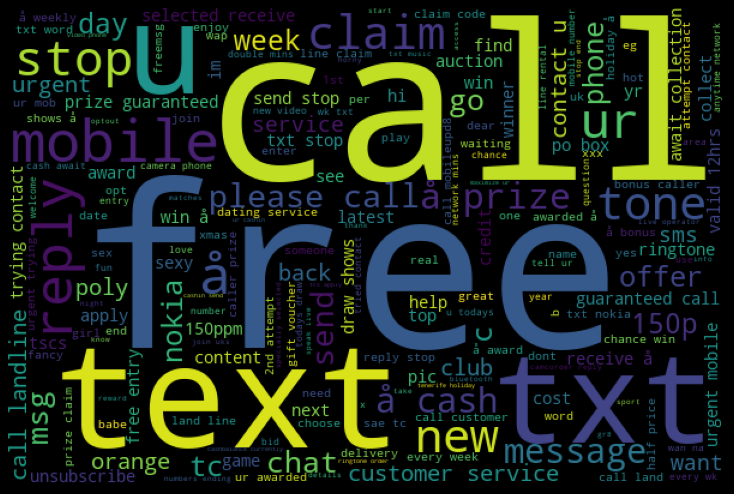

In [16]:
# Building spam word cloud 
spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

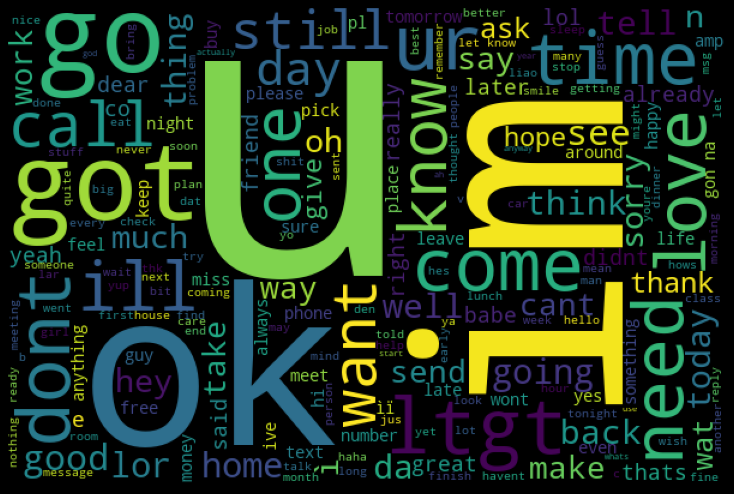

In [17]:
# Building spam word cloud 
spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### The charts give information about the words that will define the sort of message: spam or ham

### Now we make gist for see the most common words in ham and spam messages 

In [18]:
gist_1 = graph.Bar(y=[i[1] for i in Counter(spam).most_common()[:10]], x=[i[0] for i in Counter(spam).most_common()[:10]]
            , marker=dict(color = 'rgb(247, 131, 174)'))
graph.Figure(data=[gist_1]).update_layout(title="Main words in sapm")

In [19]:
gist_2 = graph.Bar(y=[i[1] for i in Counter(ham).most_common()[:10]], x=[i[0] for i in Counter(ham).most_common()[:10]]
                  ,marker=dict(color = 'rgb(35, 200, 147)'))
graph.Figure(data=[gist_2]).update_layout(title="Main words in ham")

### Now we make columns with binary value 
### Name of columns is 20 most common words in ham and spam, values is message have or not this word

In [20]:
for i in Counter(ham).most_common()[:21]:
    data[i[0]] = data['message'].map(lambda x: 1 if i[0] in x else 0)

In [21]:
for i in Counter(spam).most_common()[:21]:
    data[i[0]] = data['message'].map(lambda x: 1 if i[0] in x else 0)

In [22]:
data.head()

label                                            message  len_message  u  \
0      0  go jurong point crazy available bugis n great ...           82  1   
1      0                            ok lar joking wif u oni           23  1   
3      0                u dun say early hor u c already say           35  1   
4      0        nah dont think goes usf lives around though           43  1   
5      1  freemsg hey darling weeks word back id like fu...           87  1   

   im  get  ltgt  dont  ok  go  ...  prize  new  send  urgent  cash  nokia  \
0   0    0     0     0   0   1  ...      0    0     0       0     0      0   
1   0    0     0     0   1   0  ...      0    0     0       0     0      0   
3   0    0     0     0   0   0  ...      0    0     0       0     0      0   
4   0    0     0     1   0   1  ...      0    0     0       0     0      0   
5   0    0     0     0   1   0  ...      0    0     1       0     0      0   

   service  contact  win  please  
0        0        0    0       0  
1        0        0    0       0  
3        0        0    0       0  
4        0        0    0       0  
5        0        0    0       0  

[5 rows x 41 columns]

### Next we make columns with name "part of speech", value is how many this parts of speech in this message 


In [23]:
# Create columns
all_word = " ".join(spam+ham)
name_columns = set([i[1] for i in pos_tag(word_tokenize(all_word))])
for name in name_columns:
    data[name] = 0
data.head()

label                                            message  len_message  u  \
0      0  go jurong point crazy available bugis n great ...           82  1   
1      0                            ok lar joking wif u oni           23  1   
3      0                u dun say early hor u c already say           35  1   
4      0        nah dont think goes usf lives around though           43  1   
5      1  freemsg hey darling weeks word back id like fu...           87  1   

   im  get  ltgt  dont  ok  go  ...  IN  MD  NN  DT  VBP  JJR  RBS  JJ  VBZ  \
0   0    0     0     0   0   1  ...   0   0   0   0    0    0    0   0    0   
1   0    0     0     0   1   0  ...   0   0   0   0    0    0    0   0    0   
3   0    0     0     0   0   0  ...   0   0   0   0    0    0    0   0    0   
4   0    0     0     1   0   1  ...   0   0   0   0    0    0    0   0    0   
5   0    0     0     0   1   0  ...   0   0   0   0    0    0    0   0    0   

   VBN  
0    0  
1    0  
3    0  
4    0  
5    0  

[5 rows x 75 columns]

In [24]:
# Function for filling columns with values
def morph_stat(mes):
    part_leng = [i[1] for i in pos_tag(word_tokenize(mes))]
    index = data[data['message']==mes].index[0]
    for part in Counter(part_leng).most_common():
        data.loc[index, part[0]] = part[1]

In [25]:
# Filling columns with values 
for mes in data['message'].values:
    morph_stat(mes)
data.head()

label                                            message  len_message  u  \
0      0  go jurong point crazy available bugis n great ...           82  1   
1      0                            ok lar joking wif u oni           23  1   
3      0                u dun say early hor u c already say           35  1   
4      0        nah dont think goes usf lives around though           43  1   
5      1  freemsg hey darling weeks word back id like fu...           87  1   

   im  get  ltgt  dont  ok  go  ...  IN  MD  NN  DT  VBP  JJR  RBS  JJ  VBZ  \
0   0    0     0     0   0   1  ...   0   0   6   0    1    0    0   5    0   
1   0    0     0     0   1   0  ...   0   0   3   0    0    0    0   3    0   
3   0    0     0     0   0   0  ...   0   0   2   0    1    0    0   3    0   
4   0    0     0     1   0   1  ...   2   0   2   0    0    0    0   2    1   
5   0    0     0     0   1   0  ...   1   0   9   0    1    0    0   1    1   

   VBN  
0    0  
1    0  
3    0  
4    0  
5    0  

[5 rows x 75 columns]

### I think, we have generated enough features for training models. 
### In the next part of this notebook we will choose and training model.

In [26]:
# Make message how index
data.set_index('message', inplace=True)

In [27]:
data.head()

label  len_message  u  im  \
message                                                                         
go jurong point crazy available bugis n great w...      0           82  1   0   
ok lar joking wif u oni                                 0           23  1   0   
u dun say early hor u c already say                     0           35  1   0   
nah dont think goes usf lives around though             0           43  1   0   
freemsg hey darling weeks word back id like fun...      1           87  1   0   

                                                    get  ltgt  dont  ok  go  \
message                                                                       
go jurong point crazy available bugis n great w...    0     0     0   0   1   
ok lar joking wif u oni                               0     0     0   1   0   
u dun say early hor u c already say                   0     0     0   0   0   
nah dont think goes usf lives around though           0     0     1   0   1   
freemsg hey darling weeks word back id like fun...    0     0     0   1   0   

                                                    got  ...  IN  MD  NN  DT  \
message                                                  ...                   
go jurong point crazy available bugis n great w...    1  ...   0   0   6   0   
ok lar joking wif u oni                               0  ...   0   0   3   0   
u dun say early hor u c already say                   0  ...   0   0   2   0   
nah dont think goes usf lives around though           0  ...   2   0   2   0   
freemsg hey darling weeks word back id like fun...    0  ...   1   0   9   0   

                                                    VBP  JJR  RBS  JJ  VBZ  \
message                                                                      
go jurong point crazy available bugis n great w...    1    0    0   5    0   
ok lar joking wif u oni                               0    0    0   3    0   
u dun say early hor u c already say                   1    0    0   3    0   
nah dont think goes usf lives around though           0    0    0   2    1   
freemsg hey darling weeks word back id like fun...    1    0    0   1    1   

                                                    VBN  
message                                                  
go jurong point crazy available bugis n great w...    0  
ok lar joking wif u oni                               0  
u dun say early hor u c already say                   0  
nah dont think goes usf lives around though           0  
freemsg hey darling weeks word back id like fun...    0  

[5 rows x 74 columns]

In [28]:
# Let's split the data on feature and target
feature = data.drop(columns=['label'])
target  = data['label']

In [29]:
# For feature apply StandardScaler
std = StandardScaler()
feach = std.fit_transform(feature)

In [30]:
# Splitting data on train and test
train_feach, test_feach, train_target, test_target = train_test_split(feature, target, test_size = 0.30, random_state = 42)

In [31]:
std.fit(test_feach)
train_feach  = std.transform(train_feach)
test_feach = std.transform(test_feach)

In [32]:
# Creating models for choose best model
forest = RandomForestClassifier()
gaus = GaussianProcessClassifier()
des_tree = DecisionTreeClassifier()
svc = SVC()
k_means = KMeans(n_clusters=2)
log_reg = LogisticRegression()

In [33]:
models = [forest, gaus, des_tree, svc, k_means, log_reg]

In [34]:
# Trainig models
trainig_models = [mod.fit(train_feach, train_target) for mod in models]

In [35]:
# Calculating accuracy, precision, recall for all models
ac_score = [accuracy_score(test_target, mod.predict(test_feach)) for mod in trainig_models]
prec_score = [precision_score(test_target, mod.predict(test_feach)) for mod in trainig_models]
rec_score = [recall_score(test_target, mod.predict(test_feach)) for mod in trainig_models]

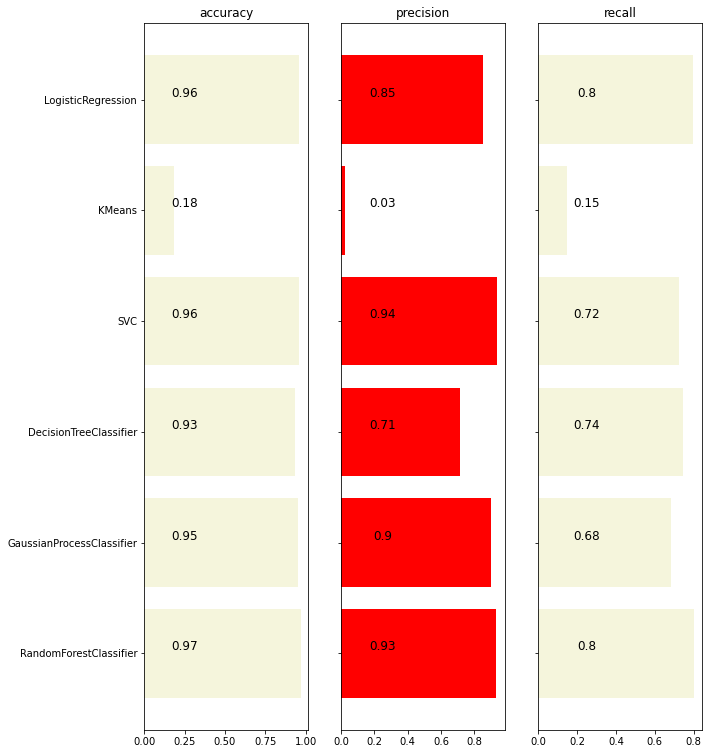

In [36]:
# Making gistogram for visualisation metrics values
name_alogoritm  = ['RandomForestClassifier', 'GaussianProcessClassifier', 'DecisionTreeClassifier',
                   'SVC', 'KMeans', 'LogisticRegression']
all_score = [ac_score, prec_score, rec_score]
name_score = ['accuracy', 'precision', 'recall']
colors = ['beige', 'red', 'beige']
fig, ax = plt.subplots(1,3,  figsize=(10, 13), sharey=True)
y_text = [i for i in range(6)]
for i in range(len(ax)):
    ax[i].barh(name_alogoritm,all_score[i], color = colors[i])
    ax[i].set_title(name_score[i])
    num = 0
    for val in  all_score[i]:
            ax[i].text(0.25, y_text[num], s=round(val, 2), horizontalalignment= 'center', verticalalignment='bottom',                               fontsize=12)
            num+=1

### Based on the results of the metrics, we choose RandomForestClassifier


In [37]:
print("0 -",round((data['label'].value_counts()[0]/data['label'].shape[0])*100), '%' )
print("1 -",round((data['label'].value_counts()[1]/data['label'].shape[0])*100), '%' )

0 - 88 %
1 - 12 %


### Our data has disbalans in the predicting class. 
### We will find the best weights of classes for model

In [38]:
# To search for the best weights, I create dict where keys is result of accuracy_score, values is weight.
# The best weight will correspond to the maximum value of the metric
best_weight = {accuracy_score(test_target, 
               RandomForestClassifier(class_weight={0:1-i, 1:i }).fit(train_feach, train_target).predict(test_feach)):i 
               for i in np.arange(0, 1, 0.001)}
print("Best weight for class 1 is ", best_weight[max(best_weight.keys())])
print("Best weight for class 0 is ", 1-best_weight[max(best_weight.keys())])

Best weight for class 1 is  0.625
Best weight for class 0 is  0.375


In [39]:
# Creating model with new weights 
rand_forest = RandomForestClassifier(class_weight={1:best_weight[max(best_weight.keys())], 0:1-best_weight[max(best_weight.keys())]})

In [40]:
# Func for finding the best train_test_split
def finde_best_split(size):
    X_tr, X_test, y_tr, y_test = train_test_split(feach, target, test_size = size, random_state=50)
    rand_forest.fit(X_tr, y_tr)
    score = accuracy_score(y_test, rand_forest.predict(X_test))
    return score

In [41]:
best_split = {finde_best_split(i):i for i in np.arange(0.1 ,1, 0.01)}
print("The best test split", best_split[max(best_split.keys())])

The best test split 0.13999999999999999


In [42]:
X_train, X_test, y_train, y_test = train_test_split(feach, target, test_size= best_split[max(best_split.keys())])

In [43]:
rand_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.375, 1: 0.625})

In [44]:
print("Result after using train_test_split with test size =0.15999999999999998\n", 
      accuracy_score(y_test, rand_forest.predict(X_test)))

Result after using train_test_split with test size =0.15999999999999998
 0.973314606741573


### Model test with cross_val_score

In [45]:
cross_val_score(rand_forest, feach, target, cv=KFold(n_splits=15), scoring=make_scorer(accuracy_score)).max()

0.9852507374631269

### We got score 0.9852507374631269 with n_splits =15, if we will boost n_splits we will get better rezult 

In [46]:
cross_val_score(rand_forest, feach, target, cv=KFold(n_splits=45), scoring=make_scorer(accuracy_score)).max()

0.9911504424778761

### But it is illusion,  when we boost n_splits, we will boost max score and will reduce mean score.
### I will show it on the plot

In [47]:
cross_for_plot = { i: cross_val_score(rand_forest, feach, target, cv=KFold(n_splits=i), scoring=make_scorer(accuracy_score)).mean()  
                 for i in range(5, 100,5)}
fig = graph.Figure()
fig.add_trace(graph.Scatter(x=list(cross_for_plot.keys()), y=list(cross_for_plot.values()), mode='lines+markers'))
fig.update_layout(title = "The dependence of cross_val_score on n_splits")
fig.show()

In [48]:
# Print finishing accuracy
print("Finishing reazult ", accuracy_score(y_test, rand_forest.predict(X_test)))

Finishing reazult  0.973314606741573


# Conclusion
We can use the nltk library to get enough numerical features from text messages to train the model. By adjusting class weights we can improve the accuracy of our model's prediction. Using cross_val_score 